In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import random
from sklearn.utils import shuffle

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

In [4]:
x_real = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_real.npz')['data']
y_real = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_real.npy')
x_hard = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_hard.npz')['data']
y_hard = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_hard.npy')
x_medium = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_medium.npz')['data']
y_medium = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_medium.npy')
x_easy = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/x_easy.npz')['data']
y_easy = np.load('/content/drive/MyDrive/ml-data/SokotoCoventryFingerprintDataset(SOCOFing)/y_easy.npy')

In [5]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
y_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)
print(x_data.shape, y_data.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


In [6]:
label_real_dict = {}
#finger feature[a b c d] to real's index
for i, y in enumerate(y_real):
  key = y.astype(str)
  key = ''.join(key).zfill(6)
  label_real_dict[key] = i

In [7]:
x_real.shape, len(label_real_dict)

((6000, 90, 90, 1), 6000)

In [8]:
import keras.layers as layers
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

inputs = layers.Input(shape=(90,90,1))
feature = layers.Conv2D(32, 32, (3, 3), padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D()(feature)
feature = layers.Conv2D(32, 32, (3, 3), padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D()(feature)
feature_model1 = tf.keras.Model(inputs=inputs, outputs=feature)

inputs = layers.Input(shape=(90,90,1))
feature = layers.Conv2D(32, 32, (3, 3), padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D()(feature)
feature = layers.Conv2D(32, 32, (3, 3), padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D()(feature)
feature_model2 = tf.keras.Model(inputs=inputs, outputs=feature)

In [9]:
x1_net = feature_model1(x1)
x2_net = feature_model2(x2)
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)
net = layers.Flatten()(net)
net = layers.Dense(64, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 15, 15, 32)   32800       ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 15, 15, 32)   32800       ['input_2[0][0]']                
                                                                                            

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [11]:
train_gen = DataGenerator(x_train, y_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, y_val, x_real, label_real_dict, shuffle=False)

In [12]:
history = model.fit_generator(train_gen, epochs=5, validation_data=val_gen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/3
1385/1385 [==============================] - 1066s 769ms/step - loss: 0.3421 - accuracy: 0.8446 - val_loss: 0.1246 - val_accuracy: 0.9498
Epoch 2/3
1385/1385 [==============================] - 1066s 770ms/step - loss: 0.2156 - accuracy: 0.9122 - val_loss: 0.0988 - val_accuracy: 0.9600
Epoch 3/3
1385/1385 [==============================] - 1062s 767ms/step - loss: 0.1872 - accuracy: 0.9261 - val_loss: 0.1097 - val_accuracy: 0.9542


In [12]:
import random

random.randint(0, 10)

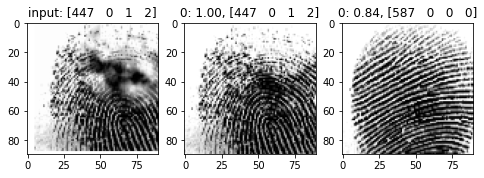

In [13]:
import random

random_index = random.randint(0, len(x_val))
random_img = x_val[random_index]
random_label = y_val[random_index]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1,90,90,1)).astype(np.float32) / 255.

# matched
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

x1 = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32)/ 255.
y1 = y_real[label_real_dict[match_key]]

pred_x1 = model.predict([random_img, x1])

# unmatched
unmatch_key, unmatch_index = random.choice(list(label_real_dict.items()))
x2 = x_real[unmatch_index].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
y2 = y_real[unmatch_index]

pred_x2 = model.predict([random_img, x2])

####

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('input: %s'%random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('0: %.02f, %s'%(pred_x1, y1))
plt.imshow(x1.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('0: %.02f, %s'%(pred_x2, y2))
plt.imshow(x2.squeeze(), cmap='gray')